# Long Trace PRF model - Demo
Here I have created a short demonstration of neuron behaviour under influence of a long trace stimulus history effect (i.e. adaptation).  The idea of this long trace model was adopted from: *Fritsche, M., Solomon, S. G., & de Lange, F. P. (2021). Brief stimuli cast a long-term trace in visual cortex. bioRxiv.*

This Notebook serves as a quick introduction in the adaptation model can be loaded, altered and displayed

## First we set everything up
#### Import some background function

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import seaborn as sns

from IPython.core.pylabtools import figsize
%matplotlib inline

### Import the longtrace_adaptation model
(function .py file should be located in the same folder [or specified otherwise])

In [2]:
import longtrace_adaptation
import longtrace_adaptation_timedomain
import longtrace_adaptation_pres

C:\Users\p70077704\Anaconda3\envs\jorie_env\lib\site-packages\nilearn\datasets\__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "
C:\Users\p70077704\Anaconda3\envs\jorie_env\lib\site-packages\nilearn\glm\__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '


## set up some kind of sequence
here we probabilistically sample from from a binominal distribution to get a interesting sequence that can be centered around two averages

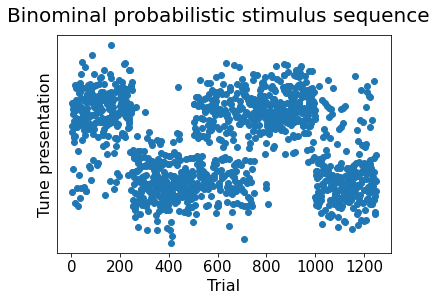

In [3]:
# set trials per blocks and number of blocks
n_blocks = 5
tpb = 250

# methed of how to jitter
jitter_method = 'gaussian'   # jitter method: gaussian, or uniform, or False
jitter_amount = 1

# set probabilities of A - B
probz = [0.5, 0.125, 0.03125, 0.875, 0.96875]
stim_values = [4, 8]

# create array to sture stimuli
stims = np.empty(n_blocks * tpb)
trails = np.arange(1, len(stims)+1)

# shuffle probability of accurence in block
random.shuffle(probz)

# loop over block and set 
for i in range(n_blocks):
    # set our probailistic numbers 
    stims[i*tpb:(i*tpb)+tpb] = np.random.choice(stim_values, tpb, p=[probz[i], 1-probz[i]])
    # add jitter
    if jitter_method == 'gaussian':
        stims[i*tpb:(i*tpb)+tpb] += np.random.normal(0, jitter_amount, size=tpb)
    elif jitter_method == 'uniform':
        stims[i*tpb:(i*tpb)+tpb] += np.random.uniform(0, jitter_amount, size=tpb)
        
# and plot
plt.scatter(trails, stims)
figsize(10, 6)

plt.suptitle('Binominal probabilistic stimulus sequence',fontsize=20);
plt.xlabel('Trial', fontsize=16)
plt.ylabel('Tune presentation', fontsize=16)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax = plt.gca()
ax.axes.yaxis.set_ticks([]);

### Adaptation decays by stimulus history

First we set our adaptation function (possibly within bounds n-1 to n-x) given four parameters.

Here we use the formula:
$f(n) = 1 - a_{fast} * exp^{(-\frac{n-1}{t_{fast}})} - a_{slow} * exp^{(-\frac{n-1}{t_{slow}})}$
Where:
+ $n$: is the number of trials back (stimulus history)
+ $a_{fast}$: magnitude of fast adaptation component
+ $t_{fast}$: recovery time of fast adaptation component
+ $a_{fast}$: magnitude of slow adaptation component
+ $t_{fast}$: recovery time of slow adaptation component

In [4]:
# set parameters for double exp decay
afast = 0.1399 
tfast = 0.85
aslow = 0.0345
tslow = 6.82

# set bound and stepsize
decay_bounds = [1, 10]
decay_stepsize = 1   # here we are interested in stimuli dimension, so we keep this set to 1

We then run a simple function that create the x and y of the decay function `double_exp_decay_func()`

In [5]:
x_decay, y_decay = longtrace_adaptation.double_exp_decay_func(afast, tfast, aslow, tslow, [1, 10], 1)

We can then plot the decay to see how it behaves using `plot_decay()`

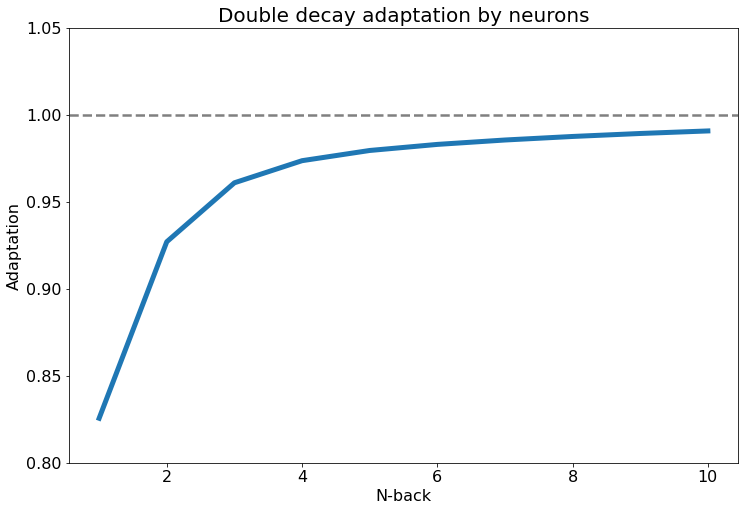

In [6]:
longtrace_adaptation.plot_decay(x_decay, y_decay)

### Adaptation over a stimulus train

Now that we have defined our stimuli sequence, and have our supposed exponential decay function we can calculate the decay over our trials.
Calculating adaptation using `stim_adaptation`, subsequently we can use `calc_adapted_activation` to weigh activation by adaptation. Raw activation is calculated using `gaussian_activation`

This `stim_adaptation` function uses as input:
* **stim_train**: the stimulus sequence
* **y_decay**: the n-back [n-1 ... n-x] decay array
* **tun_pref**: the tuning prefference of a supposed neuron
* **tun_sharp**: the sharpness of this tuning prefference
* optional, tun_peak: the peak of a tuning function, for relative standard set to 1

The function returns both the adaptation matrix and the full per n-back matrix

In [7]:
tun_pref = 3        # neuron that is tuned to '3'
tun_sharp = 1       # the broadness of the tuning (functions as the width of a gaussian)

# calculate the stimulus adaptation 
adapt, full_adaptation_matrix = longtrace_adaptation.stim_adaptation(stims, 
                                                                     y_decay, 
                                                                     tun_pref, 
                                                                     tun_sharp, 
                                                                     tun_peak=1)

# we can also calculate the raw activation without adaptation
raw_activation = longtrace_adaptation.gaussian_activations(tun_pref, 
                                                           tun_sharp, 
                                                           stims, 
                                                           tun_peak=1)

# and weigh the 'normal' activation with the adaptation
activation     = longtrace_adaptation.calc_adapted_activation(adapt, raw_activation)

To visualize what this adaptation does we can use `plot_adaptation` and `plot_adaptation_corr`

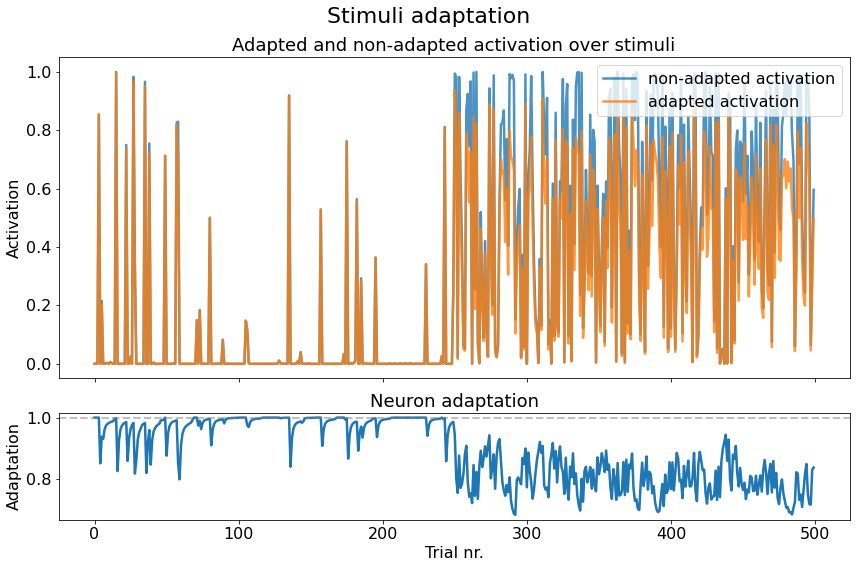

In [8]:
longtrace_adaptation.plot_adaptation(tun_pref, tun_sharp, stims[:500], y_decay);

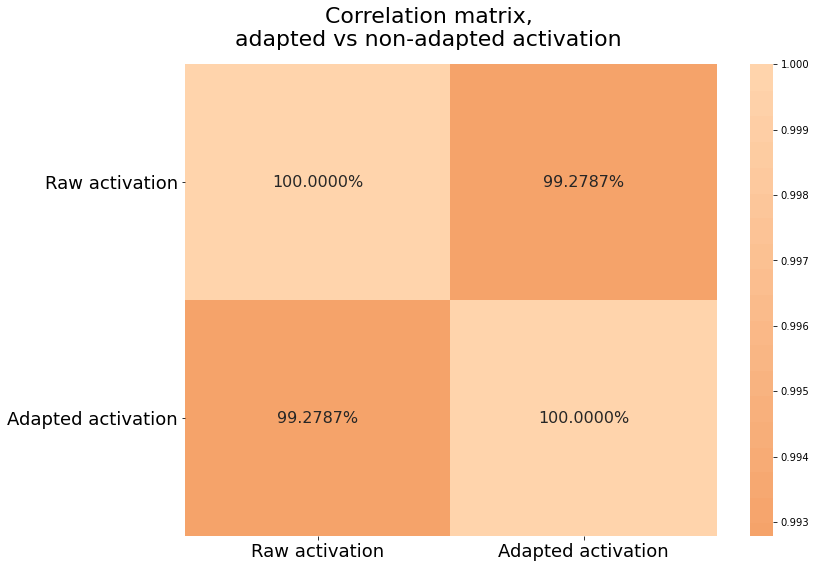

In [9]:
longtrace_adaptation.plot_adaptation_corr(tun_pref, tun_sharp, stims, y_decay);

### Multiple adaptations for all kind of neurons

Now that we know how to calculate adaptation for some neuron with a specific tuning behaviour we may want to scale this up to a range of neurons with a range of tuning sharpnesses `create_adaptation_dict`.

This function needs:
* **stim_train**: a stimulis sequence
* **y_decay**: the n-back [n-1 ... n-x] decay array
* **pref_range**: an array or list with all possible neuron prefferences
* **sharp_range**: an array or list with all sharpnesses

Function returns a dictionary with all information nested as **dict[*preffered tuning*][*tuning width*]**


In [10]:
# set range of tunings and sharpnesses
pref_range  = np.arange(1,20.25, 0.25)
sharp_range = np.round(np.arange(0.1,2.1, 0.1), 1)

# get dictionary
adapt_dict = longtrace_adaptation.create_adaptation_dict(stims, y_decay, pref_range, sharp_range)

We can do the same for raw activations using `create_activation_dict` and adapted weighted activation using `create_adapted_activation_dict`

In [11]:
# for raw activations
act_dict = longtrace_adaptation.create_activation_dict(stims, pref_range, sharp_range)
# calculate the adapted weighted activation dictionary
adp_act_dict = longtrace_adaptation.create_adapted_activation_dict(act_dict, adapt_dict)

What do we get back

In [12]:
# preffered tunings
adapt_dict.keys()

dict_keys([1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.25, 3.5, 3.75, 4.0, 4.25, 4.5, 4.75, 5.0, 5.25, 5.5, 5.75, 6.0, 6.25, 6.5, 6.75, 7.0, 7.25, 7.5, 7.75, 8.0, 8.25, 8.5, 8.75, 9.0, 9.25, 9.5, 9.75, 10.0, 10.25, 10.5, 10.75, 11.0, 11.25, 11.5, 11.75, 12.0, 12.25, 12.5, 12.75, 13.0, 13.25, 13.5, 13.75, 14.0, 14.25, 14.5, 14.75, 15.0, 15.25, 15.5, 15.75, 16.0, 16.25, 16.5, 16.75, 17.0, 17.25, 17.5, 17.75, 18.0, 18.25, 18.5, 18.75, 19.0, 19.25, 19.5, 19.75, 20.0])

In [13]:
# tuning widths
adapt_dict[1].keys()

dict_keys([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0])

In [14]:
# get adaptation for neuron with pref 4 and width 2
adapt_dict[4][2]

array([1.        , 0.98211394, 0.92266514, ..., 0.72183066, 0.69478101,
       0.68301043])

### convolve with hrf

First we set our HRF function

Text(0.5, 0, 'Time [ms]')

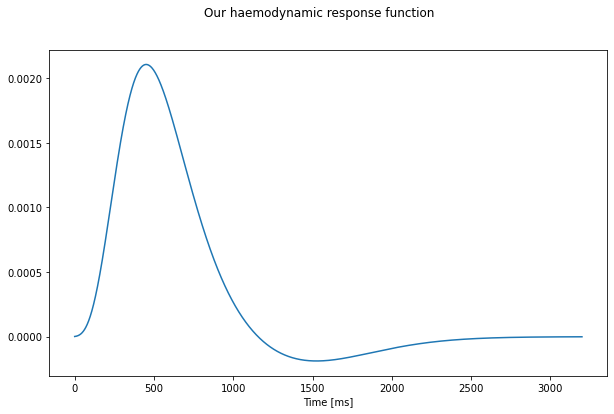

In [15]:
tr = 1
time_step   = 100  # i.e. set to miliseconds

hrf_array = longtrace_adaptation_timedomain.hrf(tr, time_step)
plt.plot(np.arange(hrf_array.shape[-1])*tr, hrf_array.ravel())
plt.suptitle('Our haemodynamic response function')
plt.xlabel('Time [ms]')

In order to convolve we have to transform our sequence into the time domain
* We can either convert the sequences themsleves (we than have to redo the activation/adaptation dictionary creation
* or we can convert the activation array to the time domain

In [16]:
stim_length = 20     # in ms
iti         = 20
time_step   = 100  # i.e. set to miliseconds
hrf_array   = longtrace_adaptation_timedomain.hrf(1, 100)

# for now we use a simple rampup by gaussian just as a proxy
stim_array = np.ones(stim_length)
stims_t = longtrace_adaptation_timedomain.sequence_to_time(stims, stim_array, iti, time_step, hrf_array)


# or we can do the same for activation of neurons
_, stim_array = longtrace_adaptation.gaussian_func(10, 4, [1, 20],1)
stims_t = longtrace_adaptation_timedomain.activation_to_time(stims, stim_array, iti, time_step, hrf_array)

This was one single sequence, for activations we can also loop over the dictionary

In [17]:
adpt_activ_dict_t = longtrace_adaptation_timedomain.activation_dict_to_time(adp_act_dict, 
                                                                            stim_array,
                                                                            iti, 
                                                                            time_step, 
                                                                            hrf_array)
activ_dict_t = longtrace_adaptation_timedomain.activation_dict_to_time(act_dict, 
                                                                       stim_array, 
                                                                       iti, 
                                                                       time_step, 
                                                                       hrf_array)

## Note. if you choose to set the sequence in the time domain, 
## you have to run create_adaptation_dict() with the new longer arrays

In [18]:
longtrace_adaptation_timedomain.sequence_to_time(stims, np.ones(stim_length), iti, time_step, hrf_array)

array([0.        , 0.        , 0.        , ..., 5.51034915, 5.51034915,
       5.51034915])

### Lets convolve 
We can easily convolve using the `np.convolve` function,

In [21]:
convolved_raw = longtrace_adaptation_timedomain.convolve(activ_dict_t[5][1], hrf_array)
convolved_adp = longtrace_adaptation_timedomain.convolve(adpt_activ_dict_t[5][1], hrf_array)

We can display the convolution and get an intuition using `plot_convolved_activation`

array([<AxesSubplot:ylabel='relative activation'>,
       <AxesSubplot:ylabel='gamma'>,
       <AxesSubplot:xlabel='time (ms)', ylabel='presented\nstim'>],
      dtype=object)

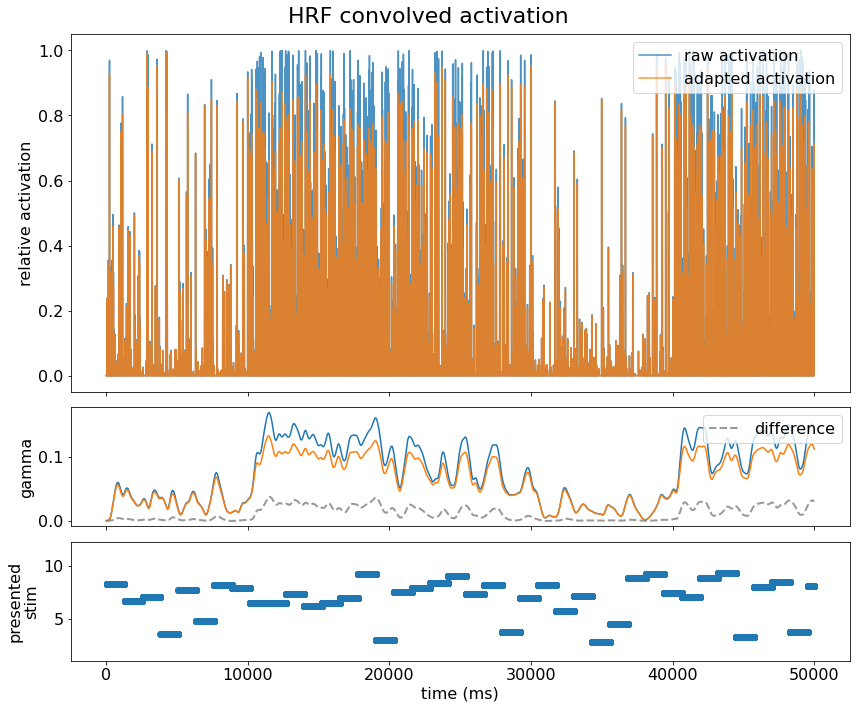

In [22]:
longtrace_adaptation_pres.plot_convolved_activation(activ_dict_t[5][1], 
                          adpt_activ_dict_t[5][1],
                          hrf_array[0],
                          stims, iti, time_step)

Next we convolve all everything in the dictionary

In [23]:
convolved_dict_raw = longtrace_adaptation_timedomain.convolve_dict(activ_dict_t, hrf_array)
convolved_dict_adap = longtrace_adaptation_timedomain.convolve_dict(adpt_activ_dict_t, hrf_array)

We have quite some simulated data at the moment, lets quickly save them using `pickle`. 
* `save_dict` saves a dict into the pickle folder, given a save name
* `load_dict` loads a dict from the pickle folder, given the save name

In [24]:
longtrace_adaptation.save_dict(convolved_dict_raw, 'hrf_convolved_unadapted')
longtrace_adaptation.save_dict(convolved_dict_adap, 'hrf_convolved_adapted')

convolved_dict_raw  = longtrace_adaptation.load_dict('hrf_convolved_unadapted')
convolved_dict_adap = longtrace_adaptation.load_dict('hrf_convolved_adapted')

## Signal correlation and variability of a sequence
**Signal correlation** between adapted activation and non adapted activation. *we want to minimize this*

**Signal variability** of the adapted(/non-adapted) signal. *we want to maximize this*

However in many cases this will be a balancing act, correlation will be lowest for highest adaptation. However, high adaptation also implies many similarities. We will take a toy example of a sequence and then look at overal correlation in that sequence. variability we can examen using fourier analyses.

#### First a simple gaussian sequence

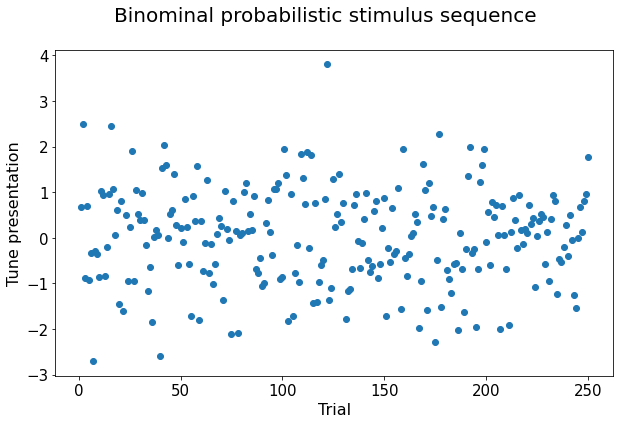

In [25]:
# set trials per blocks and number of blocks
tpb = 250
jitter_amount = 1

# set probabilities of A - B
stims = np.zeros(tpb)
trails = np.arange(1, len(stims)+1)

# set our probailistic numbers 
stims[:] += np.random.normal(0, jitter_amount, size=tpb)

# and plot
plt.scatter(trails, stims)
figsize(10, 6)

plt.suptitle('Binominal probabilistic stimulus sequence',fontsize=20);
plt.xlabel('Trial', fontsize=16)
plt.ylabel('Tune presentation', fontsize=16)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.axes.yaxis.set_ticks([]);

In [26]:
# set range of tunings and sharpnesses
pref_range  = np.arange(-2,2.25, 0.25)
sharp_range = np.round(np.arange(0.1,2.1, 0.1), 1)

# get dictionary
adapt_dict = longtrace_adaptation.create_adaptation_dict(stims, y_decay, pref_range, sharp_range)
act_dict = longtrace_adaptation.create_activation_dict(stims, pref_range, sharp_range)
adp_act_dict = longtrace_adaptation.create_adapted_activation_dict(act_dict, adapt_dict)

In [27]:
stim_length = 20     # in 10ms
iti         = 20
time_step   = 100  # i.e. set to 10miliseconds (1/100 sec)
hrf_array   = longtrace_adaptation_timedomain.hrf(1, 100)
_, stim_array = longtrace_adaptation.gaussian_func(10, 4, [1, 20],1)

adpt_activ_dict_t = longtrace_adaptation_timedomain.activation_dict_to_time(adp_act_dict, stim_array, iti, time_step, hrf_array)
activ_dict_t = longtrace_adaptation_timedomain.activation_dict_to_time(act_dict, stim_array, iti, time_step, hrf_array)

We can use `calc_correlations` and `plot_activation_correlation` to see how adapation is correlated to non-adapted activation

<AxesSubplot:title={'center':'Correlation matrix\nAdapted vs non-adapted activation'}, xlabel='tuning sharpness', ylabel='tuning prefference'>

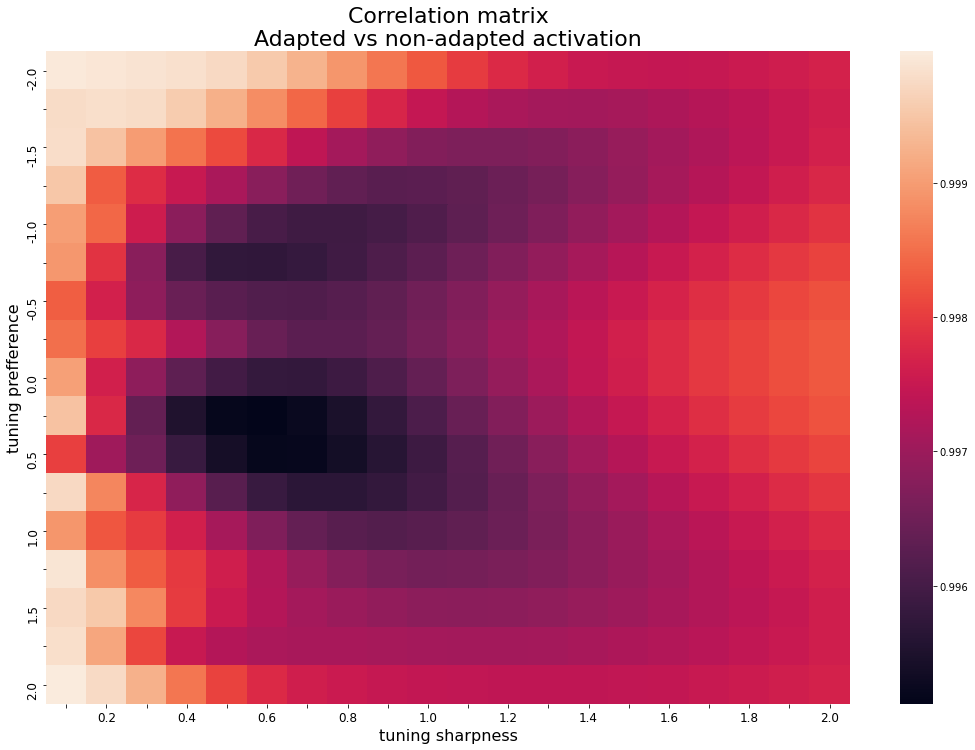

In [28]:
activation_dict = adpt_activ_dict_t
adaptation_dict = activ_dict_t

correlations = longtrace_adaptation_timedomain.calc_correlations(activation_dict, adaptation_dict)
longtrace_adaptation_pres.plot_activation_correlation(activation_dict, adaptation_dict)

And we can use `abc` and `plot_abc` to calculate and plot the variability of a sequence

<AxesSubplot:title={'center':'Standard deviation\ngiven tuning prefference and sharpness'}, xlabel='tuning sharpness', ylabel='tuning prefference'>

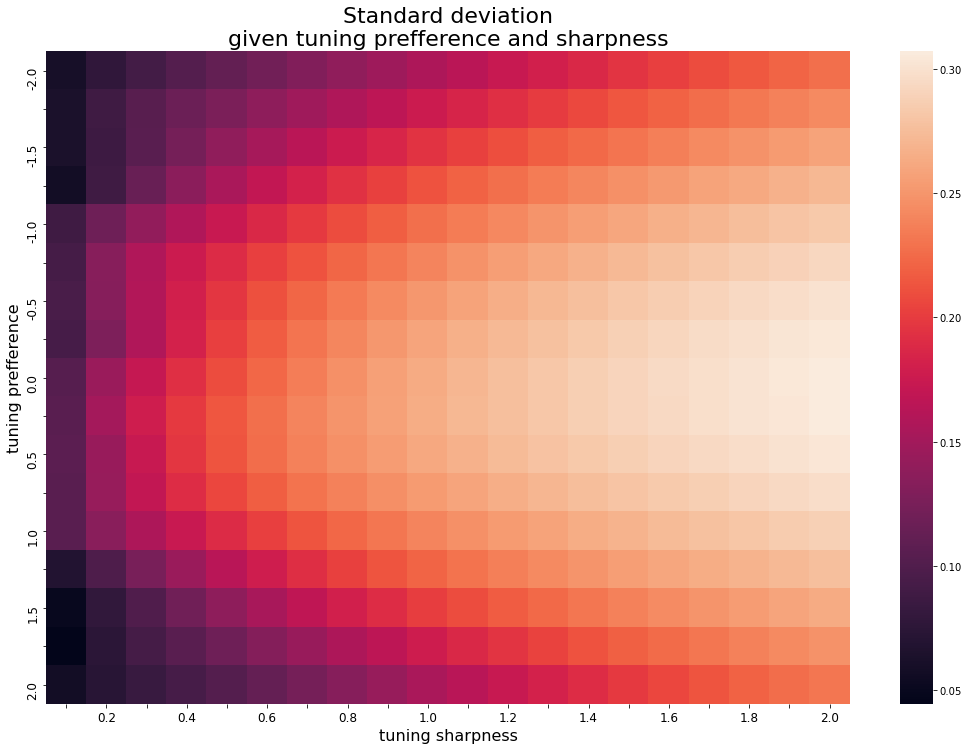

In [29]:
stds = longtrace_adaptation_timedomain.calc_stds(adaptation_dict)
longtrace_adaptation_pres.plot_stds(adaptation_dict)

#### Second a *binominal* gaussian sequence

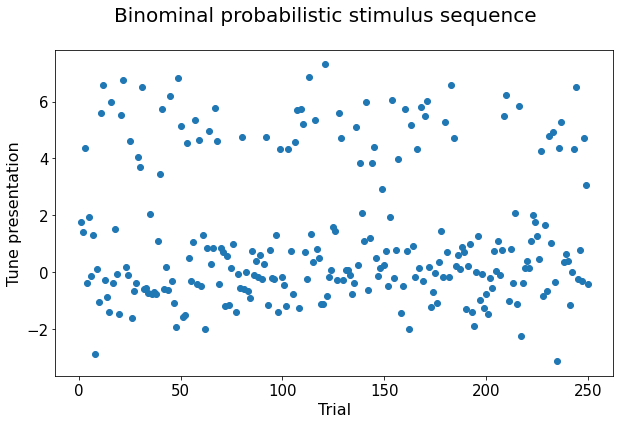

In [30]:
# set trials per blocks and number of blocks
tpb = 250
jitter_amount = 1

# set probabilities of A - B
trails = np.arange(1, len(stims)+1)
stim_values = [0.0,5.0]
p = [0.75, 0.25]
stims = np.random.choice(stim_values, tpb, p=p)

# set our probailistic numbers 
stims[:] += np.random.normal(0, jitter_amount, size=tpb)

# and plot
plt.scatter(trails, stims)
figsize(10, 6)

plt.suptitle('Binominal probabilistic stimulus sequence',fontsize=20);
plt.xlabel('Trial', fontsize=16)
plt.ylabel('Tune presentation', fontsize=16)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.axes.yaxis.set_ticks([]);

In [31]:
# set range of tunings and sharpnesses
pref_range  = np.arange(-2,8.25, 0.25)
sharp_range = np.round(np.arange(0.1,4.1, 0.1), 1)

# get dictionary
adapt_dict = longtrace_adaptation.create_adaptation_dict(stims, y_decay, pref_range, sharp_range)
act_dict = longtrace_adaptation.create_activation_dict(stims, pref_range, sharp_range)
adp_act_dict = longtrace_adaptation.create_adapted_activation_dict(act_dict, adapt_dict)

In [32]:
stim_length = 20     # in 10ms
iti         = 20
time_step   = 100  # i.e. set to 10miliseconds (1/100 sec)
hrf_array   = longtrace_adaptation_timedomain.hrf(1, 100)
_, stim_array = longtrace_adaptation.gaussian_func(10, 4, [1, 20],1)

adpt_activ_dict_t = longtrace_adaptation_timedomain.activation_dict_to_time(adp_act_dict, stim_array, iti, time_step, hrf_array)
activ_dict_t = longtrace_adaptation_timedomain.activation_dict_to_time(act_dict, stim_array, iti, time_step, hrf_array)

We can use `calc_correlations` and `plot_activation_correlation` to see how adapation is correlated to non-adapted activation

<AxesSubplot:title={'center':'Correlation matrix\nAdapted vs non-adapted activation'}, xlabel='tuning sharpness', ylabel='tuning prefference'>

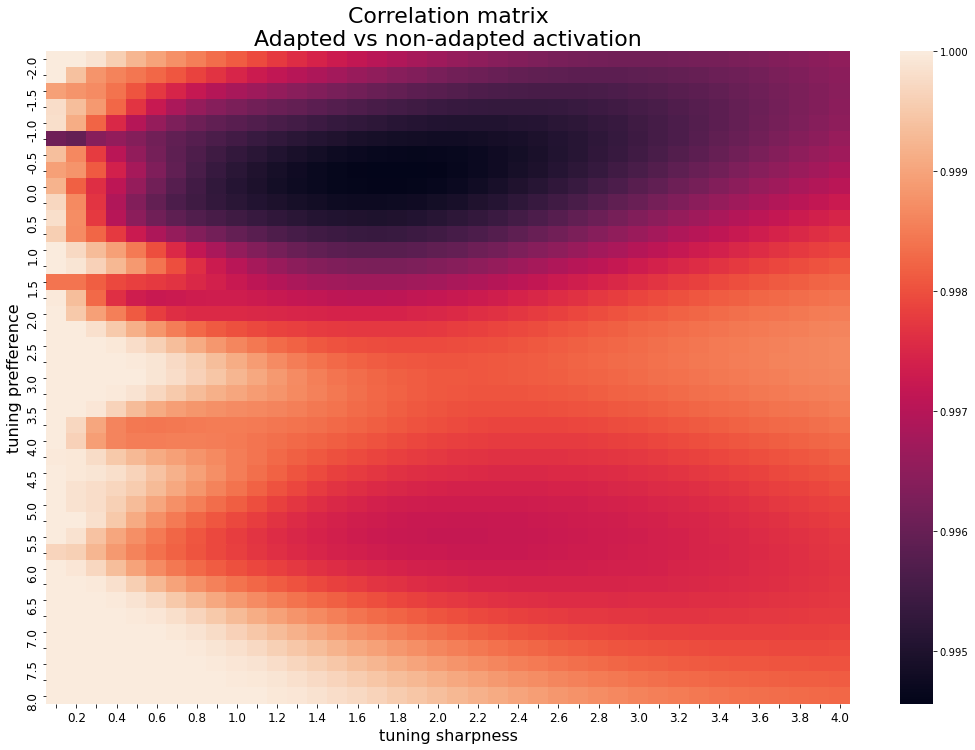

In [33]:
activation_dict = adpt_activ_dict_t
adaptation_dict = activ_dict_t

correlations = longtrace_adaptation_timedomain.calc_correlations(activation_dict, adaptation_dict)
longtrace_adaptation_pres.plot_activation_correlation(activation_dict, adaptation_dict)

And we can use `abc` and `plot_abc` to calculate and plot the variability of a sequence

<AxesSubplot:title={'center':'Standard deviation\ngiven tuning prefference and sharpness'}, xlabel='tuning sharpness', ylabel='tuning prefference'>

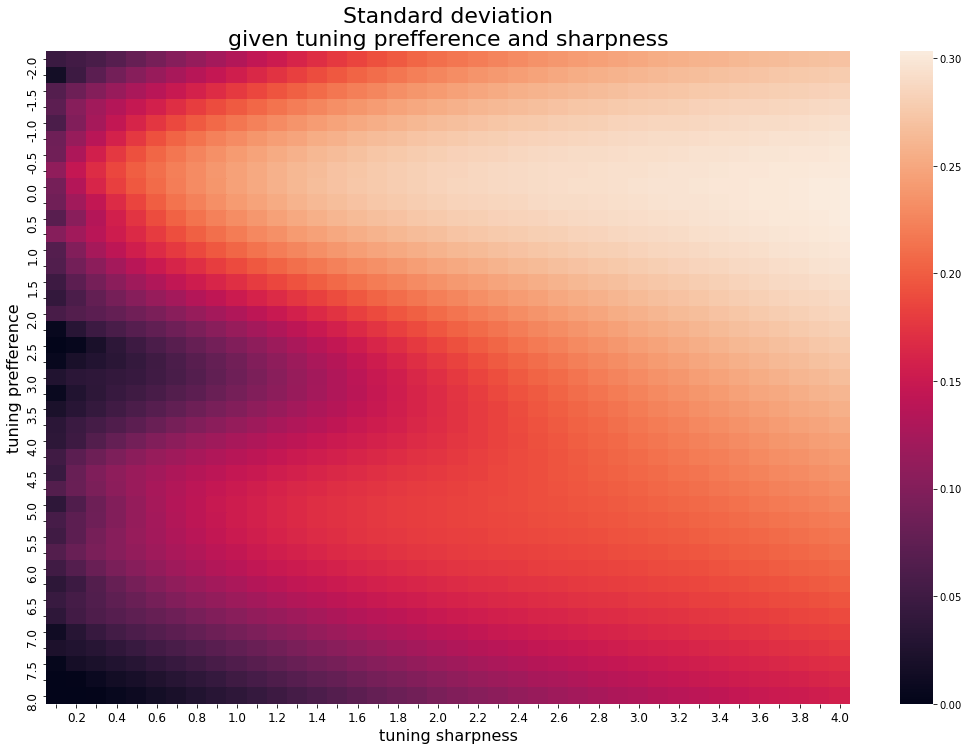

In [34]:
stds = longtrace_adaptation_timedomain.calc_stds(adaptation_dict)
longtrace_adaptation_pres.plot_stds(adaptation_dict)

#### Third a *trinominal* gaussian sequence

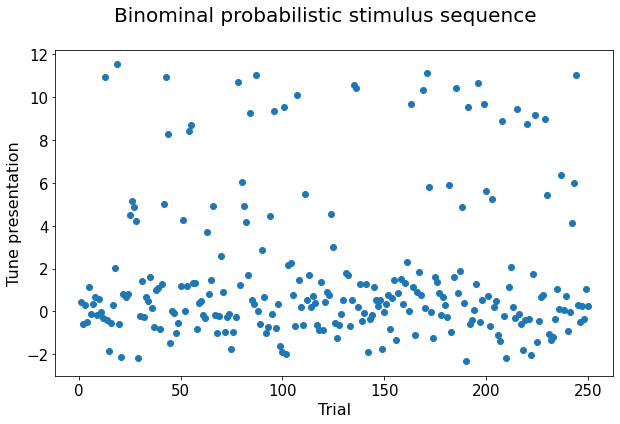

In [35]:
# set trials per blocks and number of blocks
tpb = 250
jitter_amount = 1

# set probabilities of A - B
trails = np.arange(1, len(stims)+1)
stim_values = [0.0,5.0, 10]
p = [0.75, 0.125, 0.125]
stims = np.random.choice(stim_values, tpb, p=p)

# set our probailistic numbers 
stims[:] += np.random.normal(0, jitter_amount, size=tpb)

# and plot
plt.scatter(trails, stims)
figsize(10, 6)

plt.suptitle('Binominal probabilistic stimulus sequence',fontsize=20);
plt.xlabel('Trial', fontsize=16)
plt.ylabel('Tune presentation', fontsize=16)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.axes.yaxis.set_ticks([]);

In [36]:
# set range of tunings and sharpnesses
pref_range  = np.arange(-2,8.25, 0.25)
sharp_range = np.round(np.arange(0.1,4.1, 0.1), 1)

# get dictionary
adapt_dict = longtrace_adaptation.create_adaptation_dict(stims, y_decay, pref_range, sharp_range)
act_dict = longtrace_adaptation.create_activation_dict(stims, pref_range, sharp_range)
adp_act_dict = longtrace_adaptation.create_adapted_activation_dict(act_dict, adapt_dict)

In [37]:
stim_length = 20     # in 10ms
iti         = 20
time_step   = 100  # i.e. set to 10miliseconds (1/100 sec)
hrf_array   = longtrace_adaptation_timedomain.hrf(1, 100)
_, stim_array = longtrace_adaptation.gaussian_func(10, 4, [1, 20],1)

adpt_activ_dict_t = longtrace_adaptation_timedomain.activation_dict_to_time(adp_act_dict, stim_array, iti, time_step, hrf_array)
activ_dict_t = longtrace_adaptation_timedomain.activation_dict_to_time(act_dict, stim_array, iti, time_step, hrf_array)

We can use `calc_correlations` and `plot_activation_correlation` to see how adapation is correlated to non-adapted activation

<AxesSubplot:title={'center':'Correlation matrix\nAdapted vs non-adapted activation'}, xlabel='tuning sharpness', ylabel='tuning prefference'>

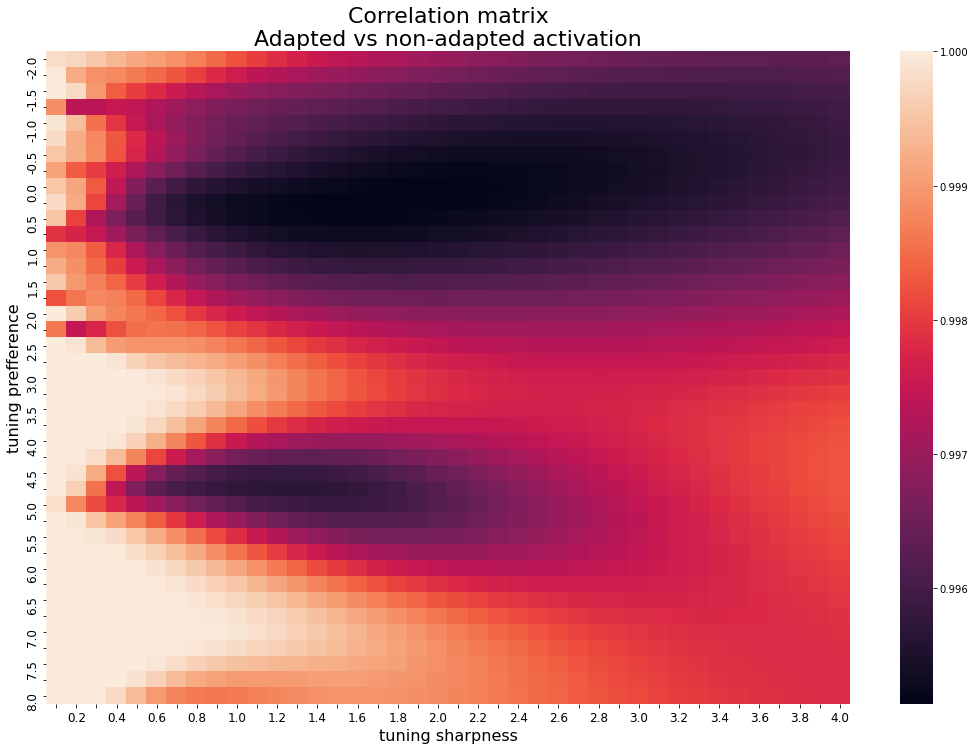

In [38]:
activation_dict = adpt_activ_dict_t
adaptation_dict = activ_dict_t

correlations = longtrace_adaptation_timedomain.calc_correlations(activation_dict, adaptation_dict)
longtrace_adaptation_pres.plot_activation_correlation(activation_dict, adaptation_dict)

And we can use `abc` and `plot_abc` to calculate and plot the variability of a sequence

<AxesSubplot:title={'center':'Standard deviation\ngiven tuning prefference and sharpness'}, xlabel='tuning sharpness', ylabel='tuning prefference'>

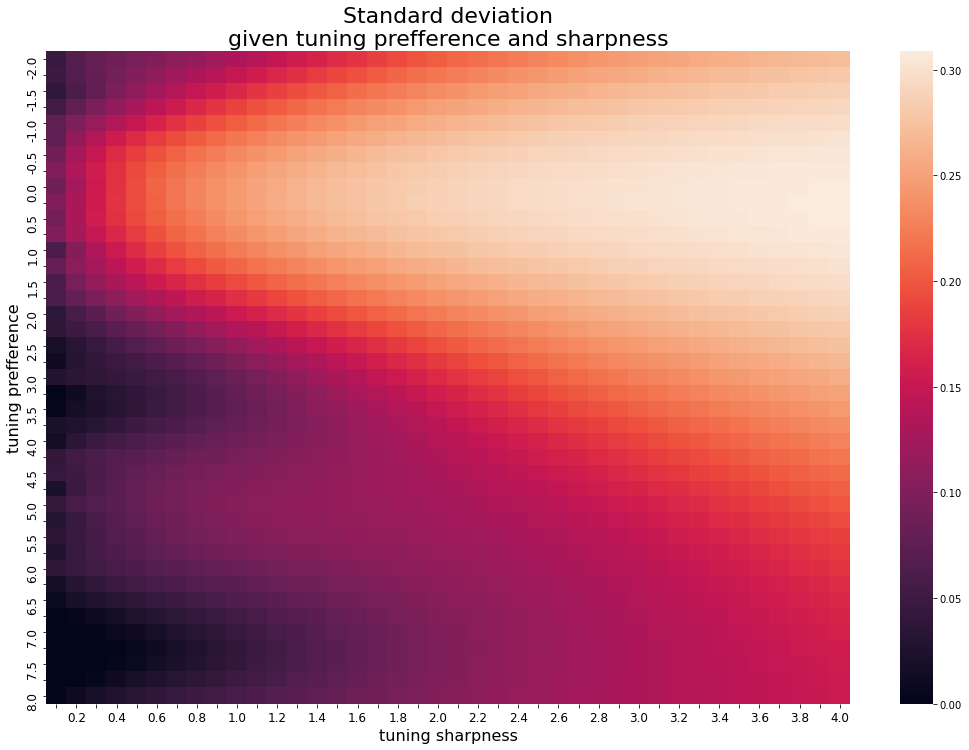

In [39]:
stds = longtrace_adaptation_timedomain.calc_stds(adaptation_dict)
longtrace_adaptation_pres.plot_stds(adaptation_dict)